# Content

In [ ]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

In [99]:
from test_toolbox import getParseTime
from test_toolbox import getMemoryUsage
from memory_profiler import memory_usage
from main import parse
import matplotlib.pyplot as plt
import numpy as np

# options for the ploting
%matplotlib inline
plt.rcParams['legend.fontsize']=15
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams['axes.labelsize']=15
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize']=8, 6

# for linear regression
from sklearn.linear_model import LinearRegression

# Implementation Analysis
The goal of th project is to check the well-formedness of an XML file and its validity according to a DTD file. We have two options: either we implement is the DOM way or the SAX way. We choose to implement the DOM technique.

First we check if the XML document has a tree stucture, it's the well-formedness. While doing that, we construct the tree of XML elements

![](Thompson_construction_rules.svg)

# Experimental Evaluation
In this section, we are going to test our XML parser on different cases:
* test 1: valid XML and valid DTD
* test 2: not well-formed XML
* test 3: not valid DTD
* test 4: well-formed but not valid XML and a valid DTD
* test 5: time execution (in seconds) with regards to size of XML document (number of nodes)
* test 6: memory consumption (in MB) with regards to size of XML document (number of nodes)


## Test 1: valid XML and valid DTD
the test is run using the files in **`test1`** folder. they contain the same XML and DTD as in the project sepecifications. The result should be : "`well-formed`" and "`valid`"

In [42]:
print("the DTD")
print("==========")
%cat test1/valid_example.dtd
print("\n==========")
print("the XML")
print("==========")
%cat test1/valid_example.xml

the DTD
a (bc)*d
b _
c _
d _
the XML
0 a
0 b
1 b
0 c
1 c
0 d
1 d
1 a

as you can see above, the XML and the DTD files are valid. Let's try to run our program on them

In [45]:
 parse('test1/valid_example.xml', 'test1/valid_example.dtd')
# the result is as expected

well-formed
valid


## Test 2: not well formed XML
the test is run using the files in folder **`test2`**. The DTD is the same on as in **Tests 1**. after executing the cell below, you can see that **`1 a`** (closing a) is missing. Thes execution should return "**`not well-formed`**" and "**`not valid`**".

In [47]:
print("the XML")
print("==========")
%cat test2/not_well_formed_example.xml

the XML
0 a
0 b
1 b
0 c
1 c
0 d
1 d


In [48]:
parse('test2/not_well_formed_example.xml', 'test2/valid_example.dtd')
# the result is as expected

not well-formed
not valid


## Test 3: not valid DTD
the test is run using the files in folder **`test3`**. The XML is the same as the one in **Test 1** but the DTD contains an error with regard to the project's specifications. After executing the cell below, you can see that the regex for **`c`** contains an opening parenthesis without a corresponding one. The output should be an error pointing to the none validity of the DTD.

In [49]:
print("the DTD")
print("==========")
%cat test3/not_valid_example.dtd

the DTD
a (bc)*d
b _
c a()(?
d _


In [51]:
parse('test3/valid_example.xml', 'test3/not_valid_example.dtd')
# the XML is still well formed but the validation of the XML is aborted because of the bad DTD.

well-formed
ERROR 0: BAD DTD !


## Test 4: well formed but not valid XML
the files are in **`test4`** folder. This time the XML is not valid. we are still using the same DTD as in **Test 1**. Remark the **`d`** element, it has a totally new element **"`e`"**, it hasn't been defined in the DTD. The ouptut should be **"`well-formed`"** and **"`not valid`"**

In [52]:
print("the XML")
print("==========")
%cat test4/not_valid_example.xml

the XML
0 a
0 b
1 b
0 c
1 c
0 d
0 e
1 e
1 d
1 a


In [54]:
parse('test4/not_valid_example.xml', 'test4/valid_example.dtd')
# the result is as expected

well-formed
not valid


## Test 5: Time execution with regards to the size of the XML
In this test we are going to generate XML files that comply to **`test5_6/exam.dtd`** file. The DTD is outputed below. It's inspired by the XML file of the exam, we modified it to make the genration of the automatons more "difficult".

The generated XML files have a specified number of nodes, it's done by always generating the same **`p`** element wich contains 10 elements (including itself). So, if we generate a file with 1000 **`p`** elements we and up with a document containg 10001 elements, the plus **1** is for the root element. For more details on the generation to the XML files have a look at **`test_toolbox.generate_exam_xml_file`** function.

To compute the amount of time used to validate each XML file, we are using **`timeit`** function which is part of the standard python library. In order to have a **robust measurment of the execution time** the validation will be rapeated **`number`** times. Otherwise a single measurment can be skewed by other processes in the system.


In [56]:
print("the DTD")
print("==========")
%cat test5_6/exam.dtd

the DTD
d p*
p nsl+
n f?g
l rco?a
s _
r _
c _
o _
f _
g _
a _


### Generation of the XML files
The XML files will be saved in **`test5_6`** folder. 200 files will be generated, the first one will contain **1001 nodes** the last one will contain **200 001 nodes**. make sure you have enough space before runing the line below.

In [74]:
from test_toolbox import generate_exam_xml_file
# the directory to put the files to
dir_path = 'test5_6'
min_nodes = 1000
nb_files = 200
for i in range(nb_files):
    generate_exam_xml_file(min_nodes * (i+1), dir_path)

In [75]:
# check the creation of the files (just the 10 first ones)
% ls test5_6/*_nodes.xml | head

test5_6/100001_nodes.xml
test5_6/10001_nodes.xml
test5_6/1001_nodes.xml
test5_6/101001_nodes.xml
test5_6/102001_nodes.xml
test5_6/103001_nodes.xml
test5_6/104001_nodes.xml
test5_6/105001_nodes.xml
test5_6/106001_nodes.xml
test5_6/107001_nodes.xml


### Measuring the execution time 
below, we are going to validate each file and record the execution time. After that we will plot the results

In [76]:
# list all the files 
file_paths = []
file_sizes = []
for i in range(nb_files):
    file_size = min_nodes * (i + 1) + 1 # the plus one is for the root element
    file_path = dir_path +"/"+ str(file_size)+"_nodes.xml"
    file_sizes.append(file_size)
    file_paths.append(file_path)

we will now validate each file. **`number`** is set to **`1`** (it's taking a lot of time to execute), but we should put a higher value in order to get more robust measurments.

In [ ]:
# validate each XML and record the execution time 
dtd_path = dir_path + '/exam.dtd'
execution_times = []
for file_path in file_paths:
    execution_time = getParseTime(file_path, dtd_path, number=1) # take the average execution time
    execution_times.append(execution_time)

below is the ploting : execution time with regards to number of nodes

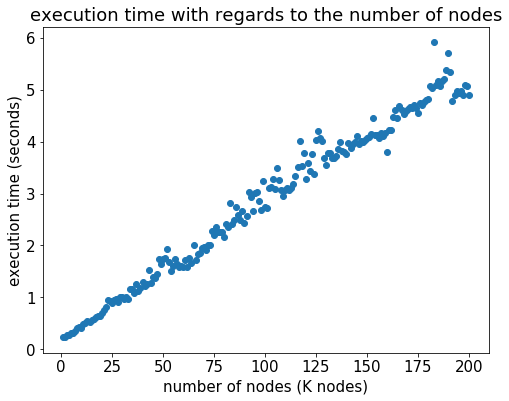

In [97]:
# in the x axis we have the number of kilo nodes (1000 nodes)
# in the y axis we have the execution time in seconds
x = np.array(file_sizes) / 1000
y = execution_times
x_label = "number of nodes (K nodes)"
y_label = "execution time (seconds)"
plot_title = "execution time with regards to the number of nodes"

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(plot_title)

# show the plot 
plt.scatter(x,y) 

according to the above plot, we see that the execution time is a linear function of the number of the nodes. Let's do a linear regression to check the slope and the intercept.

In [104]:
linear_regression = LinearRegression().fit(np.vstack(x), y)
slope = linear_regression.coef_[0]
intercept = linear_regression.intercept_
print("the function is y = "+str(slope)+" * x + "+str(intercept))

the function is y = 0.0258667170784 * x + 0.258296086998


the function and the measures are plotted below

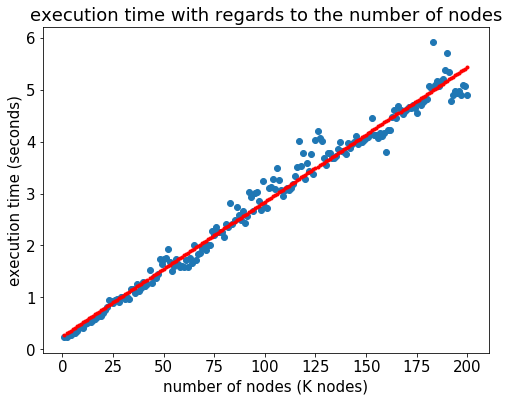

In [111]:
y_predicted = linear_regression.predict(np.vstack(x))
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(plot_title)
plt.scatter(x,y)
plt.scatter(x,y_predicted,c='r', marker='.')

the diverging points from the line are outliers. It's is probably due to the fact that the xml validation is done only once for eache file (so no averaging). So, the execution time is sensitive to other processes execution in the system while validating the XML.

**YAX Parser** is doing good according to the linear relation between the execution time and the size of the document.

## Test 6: Memory consumption with regards to the size of the XML
In this test, the memory consumption (in MB) will be evaluated using the **`memory_profiler`** module. The memory consumption assessment is implemented in **`test_toolbox.getMemoryUsage`**. Behind the scenes, our function is using **`memory_profiler.memory_usage`**. The documentation for **`memory_usage`** is saying that the memory consumption is taken every **`interval`** seconds (which is by default 0.1 seconds), we average the measures in order to have only one value.

the same files used in **Test 5** are going to be used in this test.

In [ ]:
# validate each XML and record the average amount of memory taken
# we still have the same dtd file and thes same XML files

memory_measures = []
for file_path in file_paths:
    memory_measure = getMemoryUsage(file_path, dtd_path)
    memory_measures.append(memory_measure)

below the ploting : amount of memory with regards to number of nodes

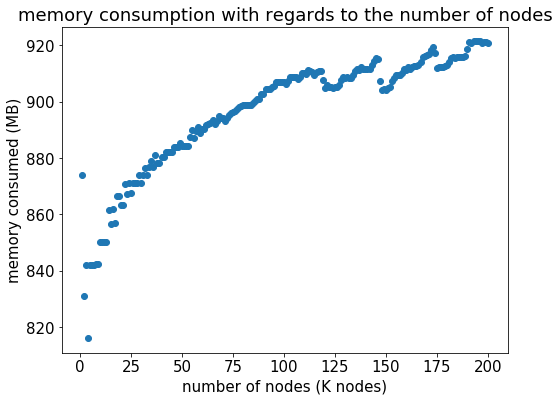

In [152]:
# in the x axis we have the number of kilo nodes (1000 nodes)
# in the y axis we have the amount (in MB) of memory consumed
x1 = np.array(file_sizes) / 1000
y1 = np.array(memory_measures)
x_label1 = "number of nodes (K nodes)"
y_label1 = "memory consumed (MB)"
plot_title1 = "memory consumption with regards to the number of nodes"

plt.xlabel(x_label1)
plt.ylabel(y_label1)
plt.title(plot_title1)

# show the plot 
plt.scatter(x1,y1) 

According to the above plot the memory consumption is logarithmique. Let's find out the min and the max values

In [144]:
# the minimum memory consumption
y1_min = np.min(y1)
x1_min = x1[y1== y1_min][0]

# the maximum memory consumptoin
y1_max = np.max(y1)
x1_max = x1[y1 == y1_max][0]

print("the file containing "+str(x1_min *1000)+ " nodes has consumed the least amount of memory, "+str(y1_min)+" MB")
print("the file containing "+str(x1_max * 1000)+" nodes has consumed the greatest amount of memory, "+ str(y1_max)+" MB")

the file containing 4001.0 nodes has consumed the least amount of memory, 816.159375 MB
the file containing 193001.0 nodes has consumed the greatest amount of memory, 921.335053066 MB


clearly the memory consumption is skewed by the activity of other processes (one of them being jupyter notebook). But, it's interesting to see that among the 200 files, the difference between the greatest and the least memory consumption is around 105 MB, especialy when you know that **`x1_max`** is 48 times bigger than **`x1_min`**. This and the shape of the plot let us suggest that there is an upper bound in the memory consumption. Let us investigate this ...

We have an intuition that the **`log`** of the size is a linear function of the amount of memory consumed. To check this, we are going to plot **`log(x1)`** with regards to **`y1`** and then do a linear regression.

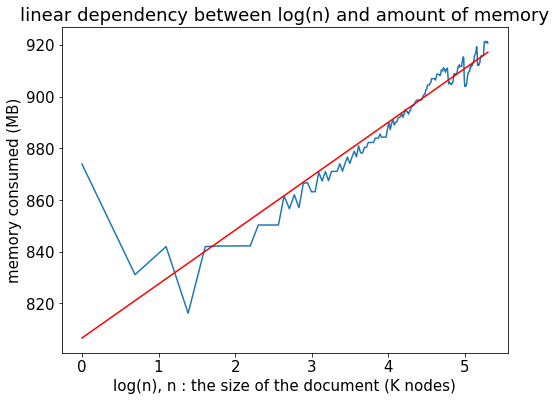

In [155]:
# computing the log of x1
log_x1 = np.log(x1)
# do the linear regression
linear_regression1 = LinearRegression().fit(np.vstack(log_x1),y1)
predicted_y1 = linear_regression1.predict(np.vstack(log_x1))

plt.xlabel("log(n), n : the size of the document (K nodes)")
plt.ylabel("memory consumed (MB)")
plt.title("linear dependency between log(n) and amount of memory")
plt.plot(log_x1,y1)
plt.plot(log_x1, predicted_y1, c='r')

**Gustav Flaubert said: " The more you approach infinity, the deeper you penetrate terror"**. I don't know if it's terror but in our case, the infinity begins to become interesting after **`x = 3`**, which  roughly corresponds to **`n = 20 000 nodes`**. The linearity between **y** (the memory consumption) and **log(n)** (the log number of nodes) is becoming clearer after that point.

The behavior of the function and its closness with the regression line around the infinite is making us confident about the linear realtion between **log(n)** and **y**.

In [34]:
%mprun -c -f parse parse('../example.xml','../example.dtd', verbose=False)

In [28]:
%memit parse('../example.xml','../example.dtd', verbose=False)

peak memory: 64.27 MiB, increment: 0.00 MiB


# Test on one file